The following notebook aims to compare different metaheuristics (optimization algorithms) in terms of their ability to find the minimum of a given function.

In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

The analysed algoritms are:
* __Particle Swarm Optimization__
* __Simulated Annealing__
* __Genetic Algorithm__

The notebooks containing implementation of abovementioned algorithms are included as separate _.py_ files.

In the future, I am going to add other algorithms such as Tabu Search and Ant Colony Optimization.

In [2]:
from SimulatedAnnealing import simulatedAnnealing
from GeneticAlgorithm import geneticAlgorithm
from ParticleSwarm import PSO

Firstly, let's define some functions which will be used as a basis for optimization. The inspiration for such functions comes from https://en.wikipedia.org/wiki/Test_functions_for_optimization. These function are widely used as a benchmark for testing the effestiveness of algorithms. All of the specified functions are $R^2 \rightarrow R$.

In [3]:
# global minimum: 0.0 (0,0)
def simple(vec):
    return vec[0]**2 + 10 * vec[1]**2

# global minimum: 0.2925 (0, 1.25313)
def schaffer(vec):
    #assert all([-100<x<100 for x in vec])
    x = vec[0]
    y = vec[1]
    return .5 + (np.sin(x**2 - y**2)**2 - .5) / (1 + .001 * (x**2 + y**2))**2

# global minimum: 0.0 [(3,2), (-2.8051, 3,1313), (-3,7793, -3,2831), (3.5844, -1.8481)]
def himmelblau(vec):
    #assert all([-5<x<5 for x in vec])
    return (vec[0]**2 + vec[1] - 11)**2 + (vec[0] + vec[1]**2 - 7)**2

# global minimum: 0.0 (1, 1)
def levi(vec):
    #assert all([-10<x<10 for x in vec])
    x=vec[0]
    y=vec[1]
    pi = np.pi
    return np.sin(3*pi*x)**2 + (x-1)**2 *(1+np.sin(3*pi*y)**2)+(y-1)**2 * \
           (1+np.sin(2*pi*y)**2)

# global minimum: -1 (pi, pi)
def easom(vec):
    x=vec[0]
    y=vec[1]
    pi=np.pi
    return -np.cos(x)*np.cos(y)*np.exp(-((x-pi)**2 + (y-pi)**2))

Now, let's set some parameters that are needed to execute the algorithms properly. The explanation of these parameters is included in respective files with algorithm implementation.

In [4]:
FUNCTIONS = [simple, schaffer, himmelblau, levi,  easom] # list of functions to optimize
X_MIN = [-20,-20]; X_MAX = [20,20]; N_ITER = 1000 # bounding box and number of iterations

# for PSO
SWARM_S = 20; C1 = 1; C2 = 1; OMEGA = .5

# for Simulated Annealing
X_INIT = [5, -3]; DELTA = .3; 

# for Genetic Algorithm
CEL = 50; POP_SIZE = 1000

# for plotting purposes
GRID_DENS = 100

Let's visualize some of the functions to get a sense of what they look like using a 3D surface plot.

Drawing plot for: schaffer
Drawing plot for: himmelblau
Drawing plot for: levi
Drawing plot for: easom


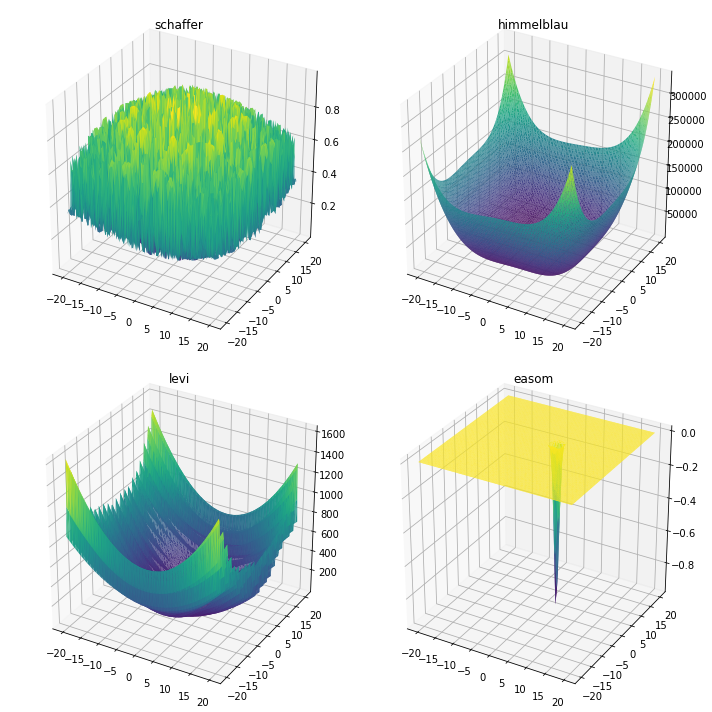

In [5]:
def draw_3d_surf(fun = [schaffer, himmelblau, levi,  easom],
                 grid_density = GRID_DENS):
    
    fig = plt.figure(figsize=(10,10))
    i = 1
    
    # create a grid of values for each function
    iks = np.linspace(X_MIN[0], X_MAX[0], grid_density)
    igr = np.linspace(X_MIN[1], X_MAX[1], grid_density)
    
    for f in fun:
        x = []; y = []; vals = []
    
        for pair in product(iks, igr):
            x.append(pair[0])
            y.append(pair[1])
            vals.append(f([pair[0], pair[1]]))
    
        # plot a 3D surfaceplot
        ax_surf = fig.add_subplot(2, 2, i, projection='3d')
        #ax_surf = fig.gca(projection='3d')
        ax_surf.plot_trisurf(x, y, vals, cmap=plt.cm.viridis,
                             linewidth=0.2)
        ax_surf.set_title(f.__name__)
        i += 1
        print('Drawing plot for: {}'.format(f.__name__))
        
    plt.tight_layout()

# Let's plot!
draw_3d_surf()   

Let's run optimization process for all of the specified function.

In [6]:
ga = {}; sa = {}; pso = {}

for fun in FUNCTIONS:
    sa[fun.__name__]  = simulatedAnnealing(f=fun, x=X_INIT, delta=DELTA, maxIter=N_ITER)
    pso[fun.__name__] = PSO(f=fun, swarm_size=SWARM_S, max_iter=N_ITER, x_min=X_MIN, x_max=X_MAX,
                            c1=C1, c2=C2, omega=OMEGA)
    ga[fun.__name__]  = geneticAlgorithm(f=fun, x_min=X_MIN, x_max=X_MAX, maxIter=N_ITER)



It's time to visualize the optimization paths for different algorithms on a 2D contourplot.

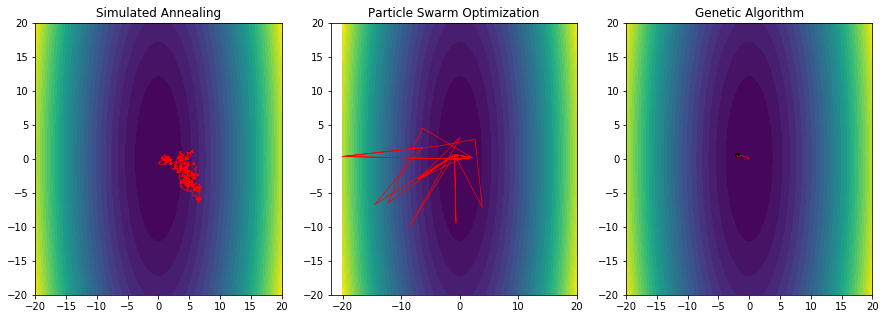

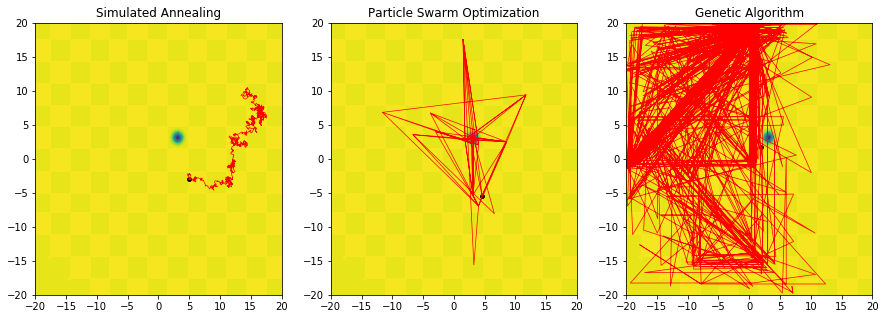

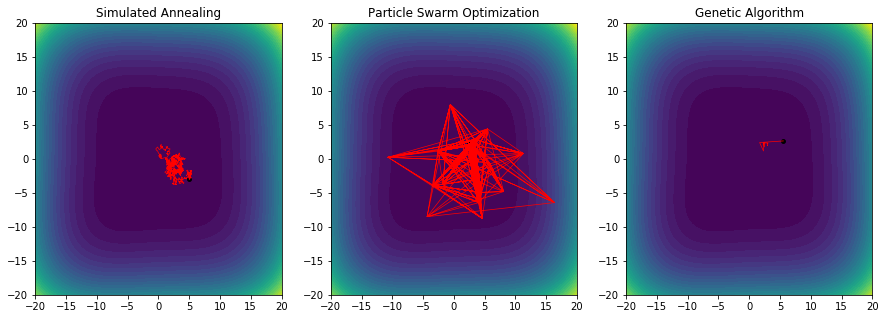

In [7]:
def draw_path(hist = [sa, pso, ga], func = 'schaffer', f_opt_hist=False):
    
    title_dict = ["Simulated Annealing", "Particle Swarm Optimization",
                  "Genetic Algorithm",]
    hist = [x[func] for x in hist]
    
    # creating grid of values for a function
    iks = np.linspace(X_MIN[0], X_MAX[0], 100)
    igr = np.linspace(X_MIN[1], X_MAX[1], 100)
    x = []
    y = []
    vals = []

    for pair in product(iks, igr):
        x.append(pair[0])
        y.append(pair[1])
        vals.append(eval(func)([pair[0], pair[1]]))
    
    # plotting
    fig = plt.figure(figsize=(15,5))
    i = 1
    
    for alg in hist:
        if f_opt_hist:
            # show only the best solution in previous iterations
            # if the best solution in a given iteration is worse than the one 
            # achieved in previous iterations, show the one from previous iterations
            new_f_hist = pd.Series(alg['f_hist']).cummin().values
            idx = [np.argwhere(alg['f_hist']==x)[0][0] for x in new_f_hist]
            alg['x_hist'] = [alg['x_hist'][i] for i in idx]
            alg['f_hist'] = new_f_hist

        path_x = [x[0] for x in alg['x_hist']]
        path_y = [y[1] for y in alg['x_hist']]

        ax = fig.add_subplot(1, 3, i)
        ax.contourf(iks, igr, np.array(vals).reshape(100,-1),
                            levels = 40)
        #ax.colorbar(cmap)
        ax.plot(path_x, path_y, 'r', linewidth=0.7)
        ax.scatter(alg['x_hist'][0][0], alg['x_hist'][0][1], s=15, c='k')
        ax.set_title(title_dict[i-1])
        
        i += 1
        
    plt.show(fig)


draw_path(func='simple', f_opt_hist=False)
draw_path(func='easom', f_opt_hist=False)
draw_path(func='himmelblau', f_opt_hist=False)
#draw_path(f_opt_hist=True)

One can notice that Simulated Annealing algorithm tends to explore the hyperspacespace in a quite unordered fashion. It takes small steps and checks many nearby solutions (perhaps increasing _delta_ parameter would enable bigger hops and more aggresive hyperspace exploration).

The optimization paths for Particle Swarm Optimization seem to make explore large part of the hyperspace. Each point is the solution for the best particle in a given iteration. Linear jumps result from its _vector-like_ nature.

Genetic Algorithm seems to be finding the optimum point quite quickly. For a simple and himmelblau function it found the optimum solution within the first iterations and for easom function it explored the hyperspace aggresively but could't find the (1,1) optimum.

In order to see how the algorithm changed the solution from iteration to iteration let's create an animation. The following animation shows the optimization path for PSO algorithm for a simple function (it may take a minute or so to save a gif).

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


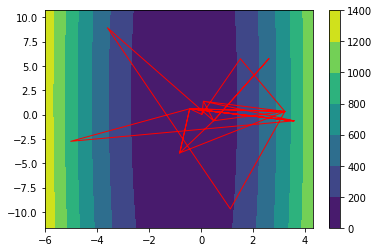

In [30]:
anim_pso = PSO(f=simple, swarm_size=SWARM_S, max_iter=N_ITER,
               x_min=X_MIN, x_max=X_MAX, c1=C1, c2=C2, omega=OMEGA)

def draw_anim(hist=anim_pso, func='simple',
              save_to_disk=False, file_name='animated_path.gif'):
    
    x_min = 1.2 * np.amin(hist['x_hist'], 0)
    x_max = 1.2 * np.amax(hist['x_hist'], 0)
    
    # creating grid of values for a function
    iks = np.linspace(x_min[0], x_max[0], 100)
    igr = np.linspace(x_min[1], x_max[1], 100)
    x = []
    y = []
    vals = []

    for pair in product(iks, igr):
        x.append(pair[0])
        y.append(pair[1])
        vals.append(eval(func)([pair[0], pair[1]]))
    
    # drawing static contourplot of function
    fig, ax = plt.subplots()
    ax.scatter(hist['x_hist'][0][0], hist['x_hist'][0][1], s=20, c='k')
    cmap = ax.contourf(iks, igr, np.array(vals).reshape(GRID_DENS, -1))
    fig.colorbar(cmap)
    line, = ax.plot([], [], 'r-', linewidth=1)
    
    def init_fn():
        return line,
    
    # defining update function
    def update_gif(i):
        x_tmp = [x[0] for x in hist['x_hist']]
        y_tmp = [x[1] for x in hist['x_hist']]
        
        line.set_xdata(x_tmp[:i])
        line.set_ydata(y_tmp[:i])
        return line,
        
    ani = FuncAnimation(fig, update_gif, init_func = init_fn, interval=100,
                        blit=True, frames=np.arange(1, len(hist['x_hist'])))
    
    if save_to_disk:
        ani.save('./gifs/' + file_name) # writer='imagemagick'
    else:
        plt.show()


draw_anim(save_to_disk=True, file_name='pso_simple.gif')